# Forecasting with Dynamic Linear Model (DLM)

Among state space models, Dynamic Linear Model (DLM) are one of the most popular models due to its explainability and ability to incorporate regressors with dynamic coefficients. This notebook introduces a way to construct a vanlia DLM through Pyro and Forecaster modules. In the end, it provides an extension to coefficients priors incorporation.

See also:
- [Forecasting II: state space models](http://pyro.ai/examples/forecasting_ii.html)

#### Workflow 
1. data simulation
2. visualization of coefficients and response
3. Standard DLM training and validation
    - posteriors comparison
    - holdout validation
4. DLM with coefficients priors at various time points
    - posteriors comparison
    - holdout validation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.stats import quantile

%matplotlib inline
assert pyro.__version__.startswith('1.4.0')

pyro.enable_validation(True)
pyro.set_rng_seed(20200221)

pd.set_option('display.max_rows', 500)
plt.style.use('fivethirtyeight')

## Data Simulation

Assume we have observation $y_t$ at time $t$ such that 
$$y_t = x_t^T \beta_t + \epsilon_t$$
$$\beta_t = \beta_{t-1} + \delta_t$$
where

$x_t$ is a P x 1 vector of regressors at time $t$

$\beta_t$ is a P x 1 vector of latent coefficients at time $t$ following a random walk distribution

$\epsilon$ is the noise at time $t$

We then simulate data in following distribution:
$$x_t \sim \mathcal{N}_p(0, \sigma_x^2)$$
$$\delta_t \sim \mathcal{N}_p(0, \sigma_{\delta}^2)$$
$$\epsilon_t \sim \mathcal{N}(0, \sigma_y^2)$$

In [213]:
np.random.seed(20200820)
# number of predictors, total observations
p = 5
n = 365 * 3

# start, train end, test end
T0 = 0            
T1 = n - 28
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.from_numpy(np.cumsum(np.random.normal(0, 0.3, n))).unsqueeze(-1)
betas_p = torch.from_numpy(np.cumsum(np.random.normal(0, 0.05, size=(n, p)), axis=0))
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), torch.from_numpy(np.random.normal(2, 1, size=(n, p)))],
    dim=-1
)
# observation with noise
y = ((covariates * betas).sum(-1) + torch.from_numpy(np.random.normal(0, 0.1, n))).unsqueeze(-1)

## Visualization of response and coefficients

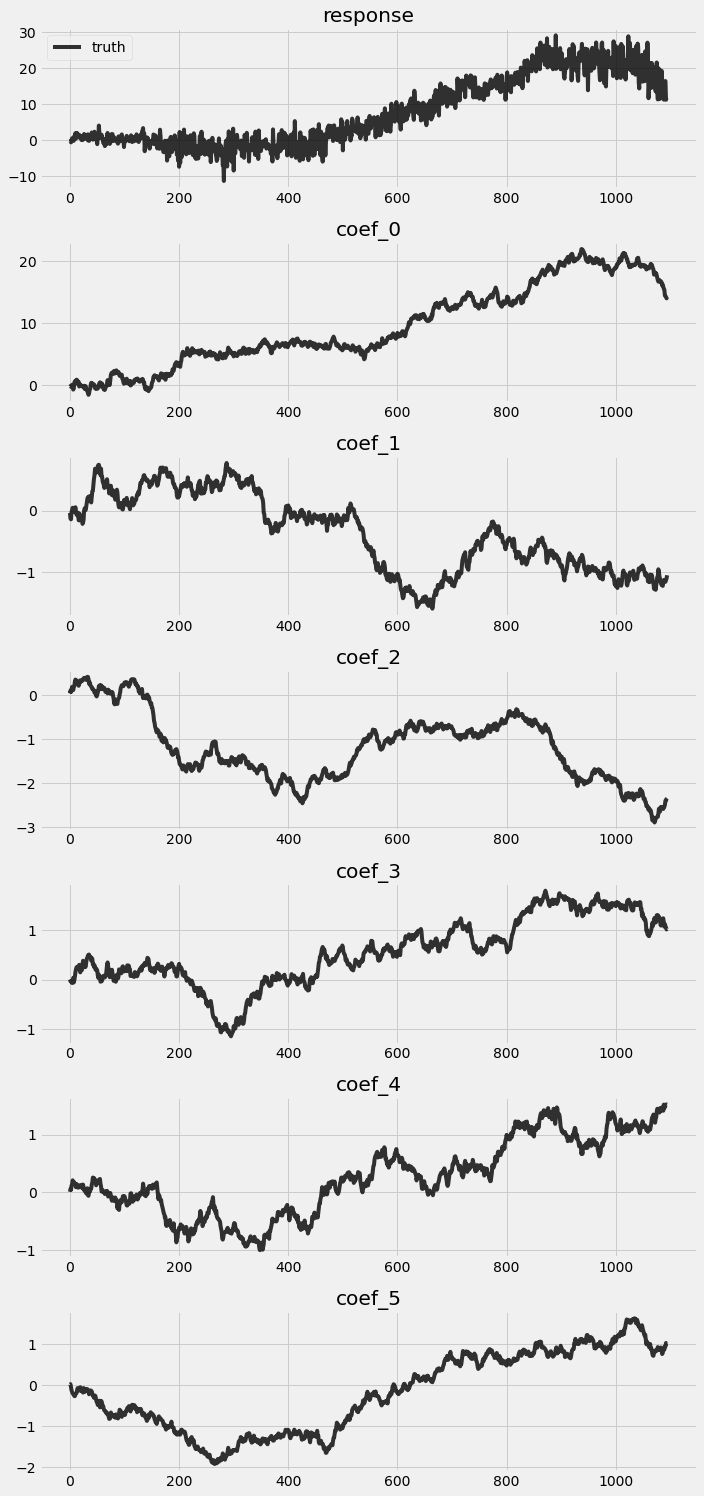

In [214]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

## Train and validate a vanlia DLM

In [215]:
class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-5, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [216]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(DLM(), y[:T1], covariates[:T1], learning_rate=0.1, num_steps=2000)

INFO 	 step    0 loss = 5.89572e+14
INFO 	 step  100 loss = 2972.41
INFO 	 step  200 loss = 7.7411
INFO 	 step  300 loss = 4.30975
INFO 	 step  400 loss = 3.59656
INFO 	 step  500 loss = 3.53126
INFO 	 step  600 loss = 4.26568
INFO 	 step  700 loss = 3.27292
INFO 	 step  800 loss = 3.23623
INFO 	 step  900 loss = 3.26911
INFO 	 step 1000 loss = 3.0197
INFO 	 step 1100 loss = 3.07567
INFO 	 step 1200 loss = 3.26283
INFO 	 step 1300 loss = 3.49129
INFO 	 step 1400 loss = 2.67453
INFO 	 step 1500 loss = 3.21152
INFO 	 step 1600 loss = 2.99825
INFO 	 step 1700 loss = 2.67257
INFO 	 step 1800 loss = 2.70983
INFO 	 step 1900 loss = 2.58617


CPU times: user 15.4 s, sys: 53.3 ms, total: 15.5 s
Wall time: 15.5 s


### Posteriors comparison

We extract posteriors during the in-sample period and compare them against the truth.

In [217]:
num_samples = 100
dim = -2
with torch.no_grad():
    # record the VI samples from the guide
    with poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.guide(y[:T1], covariates[:T1])
    guide_trace = tr.trace

    # replay the model against the posteriors samples
    with poutine.replay(trace=guide_trace), poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.model(y[:T1], covariates[:T1])

    # extract the values from the recorded 
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }
    
prediction = posterior_samples["prediction"].median(0).values
posterior_weight_mean = posterior_samples['weight'].median(0).values

In [218]:
forecaster.guide()['drift_scale']

tensor([0.0845, 0.0007, 0.0117, 0.0009, 0.0011, 0.0005],
       grad_fn=<ExpandBackward>)

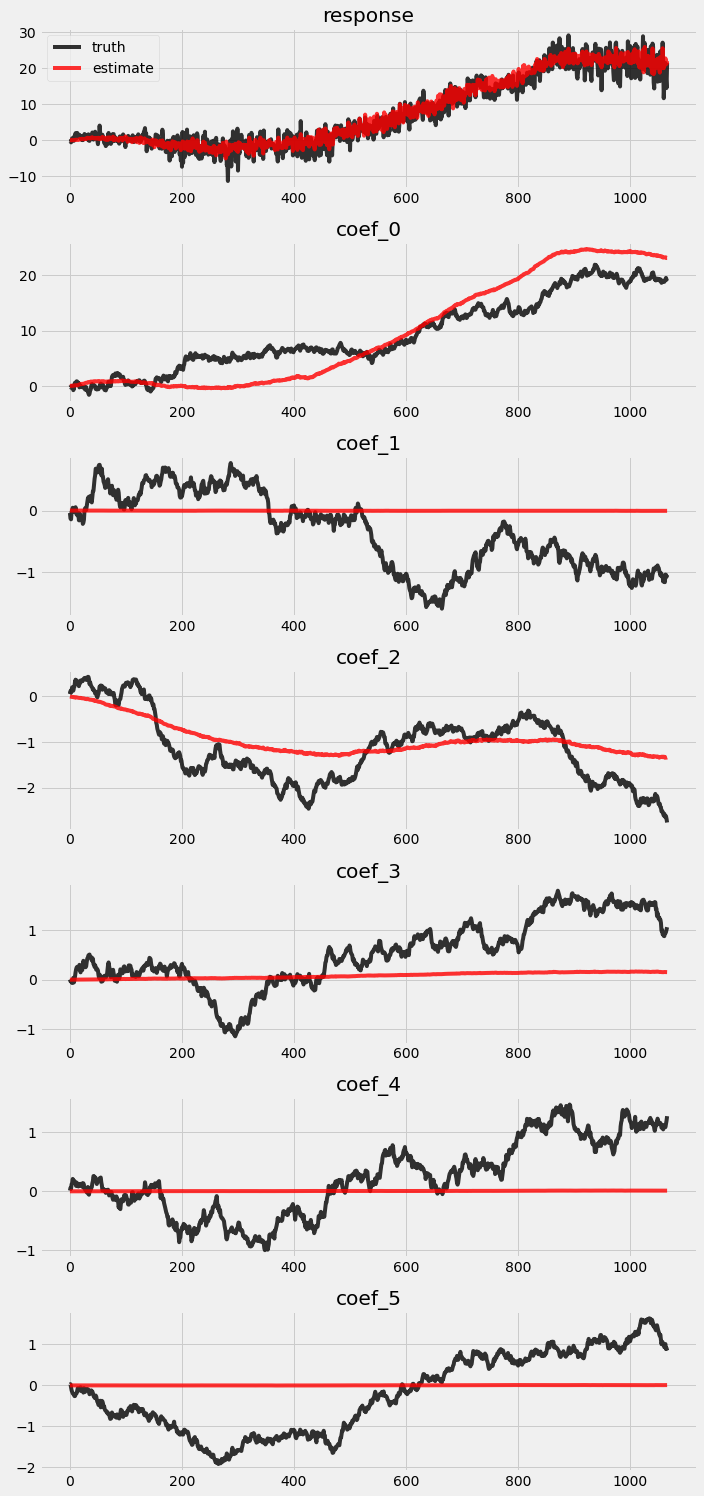

In [219]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8)
        axes[0].plot(prediction, 'r-', label='estimate', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].plot(posterior_weight_mean[:, idx - 1], 'r-', label='estimate', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

### Holdout validation

torch.Size([1000, 28, 1]) torch.Size([28])


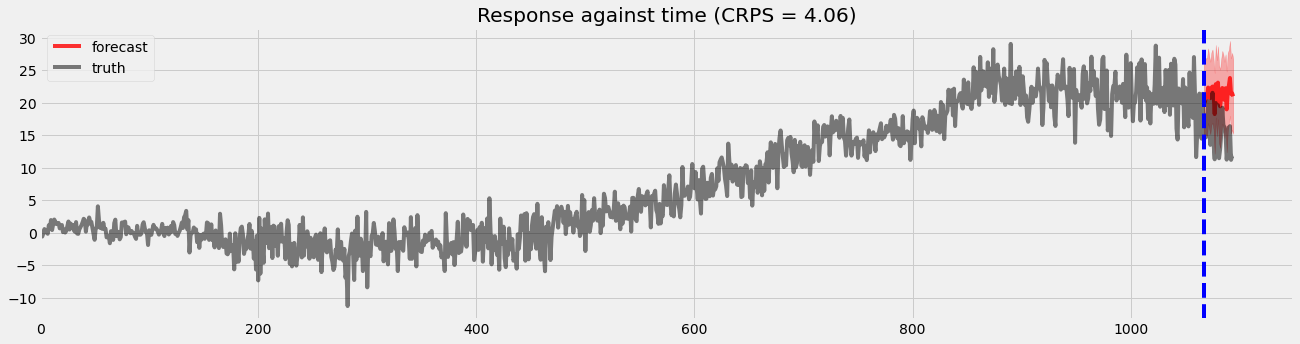

In [220]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Train a DLM with coefficients priors at various time points

Sometime user may have prior beliefs of certain coefficients at certain time point. This is especially practical to applications on business where modelers can perform experiments at certain point. In that sense, we should provide an informative prior since experiments usually yield stronger casuality measure. For illustration, we create a simple evenly distributed time points and set priors on those points with the known value $B_t$. Hence, 
$$ \beta_t \sim \mathcal{N}_p(B_t, 0.1)$$ such that $t \in [t_1, t_2, ... t_n]$ and $[t_1, t_2, ... t_n]$ are the time points we have experiential results.

In [228]:
# let's provide some priors
time_points = [200, 400, 600, 800]
# exclude intercept
priors = betas[time_points, 1:]
priors.shape

torch.Size([4, 5])

### Model Training

In [229]:
class DLM2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-5, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight)
        # coef. priors injection 
        for t, prior in zip(time_points, priors):
            pyro.sample("weight_prior_{}".format(t), dist.Normal(prior, 1e-1).to_event(1), obs=weight[..., t:t+1, 1:]) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [230]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(DLM2(), y[:T1], covariates[:T1], learning_rate=0.1, num_steps=2000)

INFO 	 step    0 loss = 5.89572e+14
INFO 	 step  100 loss = 2972.31
INFO 	 step  200 loss = 8.00857
INFO 	 step  300 loss = 4.82191
INFO 	 step  400 loss = 3.96313
INFO 	 step  500 loss = 3.66614
INFO 	 step  600 loss = 3.95033
INFO 	 step  700 loss = 3.45321
INFO 	 step  800 loss = 3.80163
INFO 	 step  900 loss = 3.46185
INFO 	 step 1000 loss = 4.58269
INFO 	 step 1100 loss = 3.038
INFO 	 step 1200 loss = 3.40333
INFO 	 step 1300 loss = 4.40635
INFO 	 step 1400 loss = 2.86999
INFO 	 step 1500 loss = 2.85954
INFO 	 step 1600 loss = 2.85301
INFO 	 step 1700 loss = 3.01417
INFO 	 step 1800 loss = 4.36357
INFO 	 step 1900 loss = 2.77779


CPU times: user 18.5 s, sys: 69.1 ms, total: 18.5 s
Wall time: 18.6 s


### Posterior comparison

In [231]:
num_samples = 100
dim = -2
with torch.no_grad():
    # record the VI samples from the guide
    with poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.guide(y[:T1], covariates[:T1])
    guide_trace = tr.trace

    # replay the model against the posteriors samples
    with poutine.replay(trace=guide_trace), poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.model(y[:T1], covariates[:T1])

    # extract the values from the recorded 
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }
    
prediction = posterior_samples["prediction"].median(0).values
posterior_weight_mean = posterior_samples['weight'].median(0).values

In [232]:
forecaster.guide()['drift_scale']

tensor([0.0738, 0.0088, 0.0148, 0.0078, 0.0123, 0.0102],
       grad_fn=<ExpandBackward>)

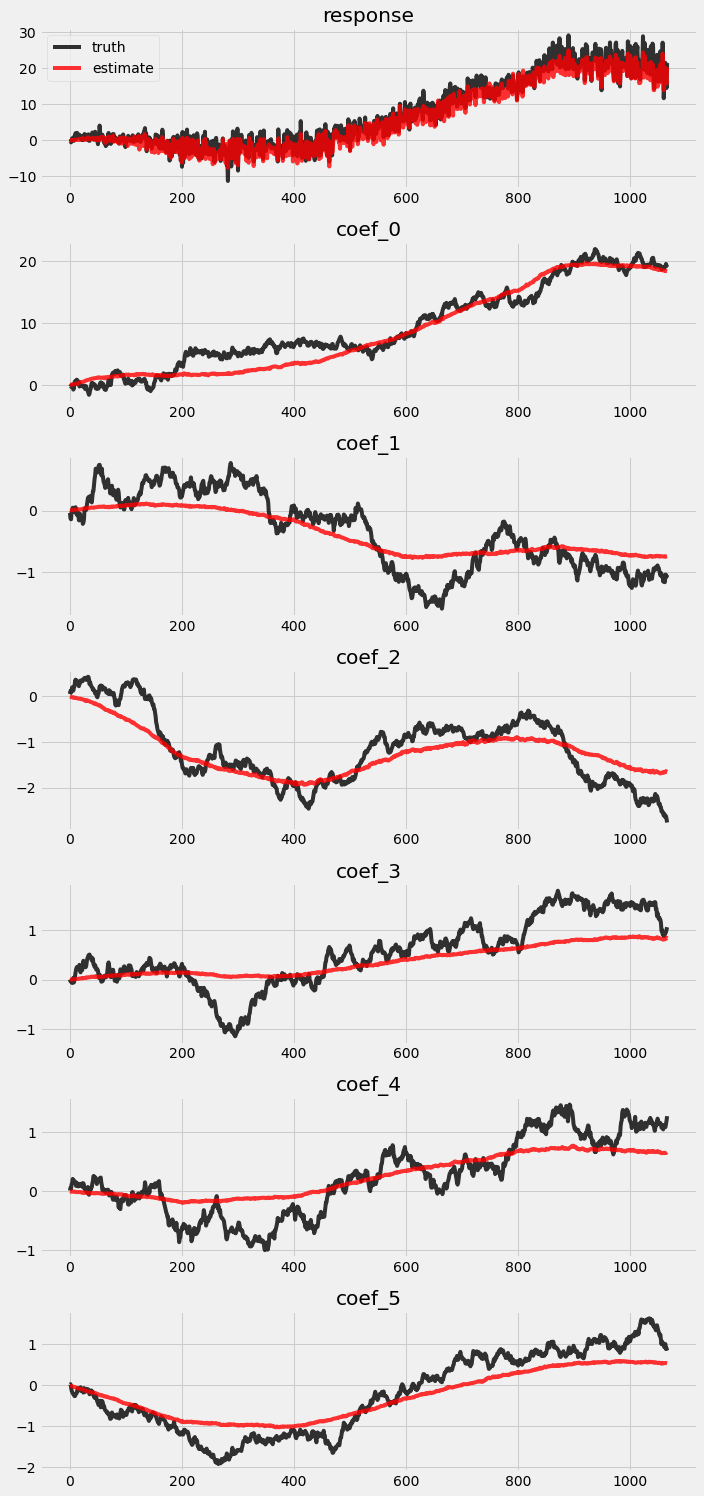

In [233]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8)
        axes[0].plot(prediction, 'r-', label='estimate', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].plot(posterior_weight_mean[:, idx - 1], 'r-', label='estimate', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

### Holdout validation

torch.Size([1000, 28, 1]) torch.Size([28])


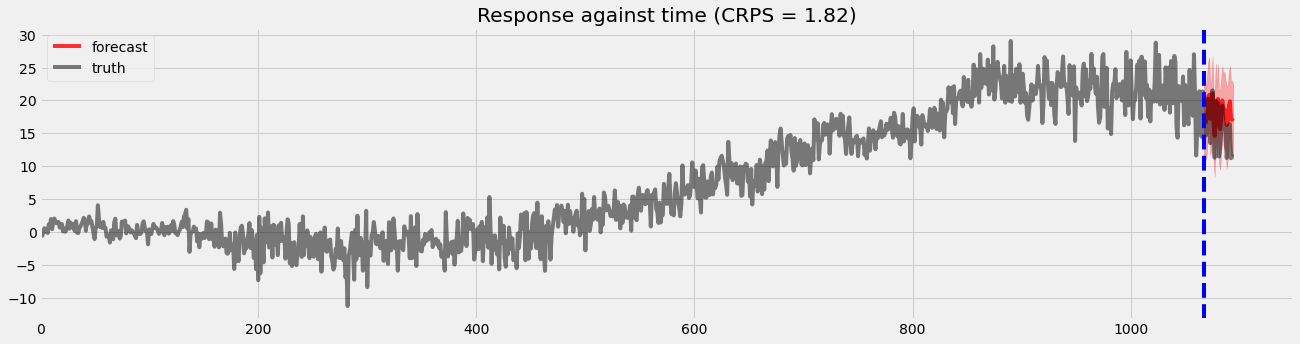

In [234]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Conclusion

1. We finish a DLM model in Pyro provides decent forecast with simulated dataset
2. We see a trendmendous improvement on posteriors sampling and out-of-sample prediction CRPS after priors injection.
3. DLM allowing priors injection is practical in modeling business where user can perform experimentations from time to time.

## Reference
- Harvey, C. A. (1989). *Forecasting, Structural Time Series and the Kalman Filter*, Cambridge University Press.
- Durbin, J., Koopman, S. J.. (2001). *Time Series Analysis by State Space Methods*, Oxford Statistical Science Series
- Scott, S. L., and Varian, H. (2015). "Inferring Causal Impact using Bayesian Structural Time-Series Models" The Annals of Applied Statistics, 9(1), 247–274.
- Moore, D., Burnim, J, and the TFP Team (2019). "Structural Time Series modeling in TensorFlow Probability" Available at [https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html)